In [2]:
import os
import io
from construct import *
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
import numpy as np

from IPython.display import HTML
from matplotlib import animation, rc

Set up the construct definition. 

In [59]:
filename = "./xwr16xx_processed_stream_2019_05_10T09_33_28_999.dat"
#filename = "./xwr16xx_processed_stream_2019_05_06T14_46_38_043.dat"
#filename = "./xwr16xx_processed_stream_2019_05_07T16_24_49_846.dat"
rangeFFTSize = 256
dopplerFFTSize = 256
antennas = 8

from enum import Enum
class Message(Enum):
    MMWDEMO_OUTPUT_MSG_DETECTED_POINTS = 1
    MMWDEMO_OUTPUT_MSG_RANGE_PROFILE = 2 
    MMWDEMO_OUTPUT_MSG_NOISE_PROFILE = 3
    MMWDEMO_OUTPUT_MSG_AZIMUT_STATIC_HEAT_MAP = 4
    MMWDEMO_OUTPUT_MSG_RANGE_DOPPLER_HEAT_MAP = 5
    MMWDEMO_OUTPUT_MSG_POINT_CLOUD = 6
    MMWDEMO_OUTPUT_MSG_TARGET_LIST = 7
    MMWDEMO_OUTPUT_MSG_TARGET_INDEX = 8
    MMWDEMO_OUTPUT_MSG_STATS = 9
    MMWDEMO_OUTPUT_MSG_MAX = 10
    
    
frame = Aligned(4,
    Struct(
    #Find sync bytes by looping over untill we find the magic word
    "sync" / RepeatUntil(lambda x, lst, ctx : lst[-8:] == [0x02, 0x01, 0x04, 0x03, 0x06, 0x05, 0x08, 0x07], Byte),
    "header" / Struct(
        "version" / Int32ul,
        'platform' / Int32ul, 
        'timestamp' / Int32ul,
        'totalPacketLen' / Int32ul, 
        'frameNumber' / Int32ul, 
        'subframeNumber' / Int32ul,
        'chirpProcessingMargin' / Int32ul, 
        'frameProcessingMargin' / Int32ul, 
        'trackingProcessingTime' / Int32ul,
        'uartSendingTime' / Int32ul,
        'numTLVs' / Int16ul, 
        'checksum' / Int16ul,
    ),
    "packets" / Struct(
             "type" / Int32ul,
             "len" / Int32ul,
             "data" / Switch(this.type,
                {
                Message.MMWDEMO_OUTPUT_MSG_POINT_CLOUD.value: 
                    "objects" / Struct(
                        "range" / Float32b,
                        "angle" / Float32b,
                        "doppler" / Float32b,
                        "snr" / Float32b,
                    )[lambda ctx: int((ctx.len - 8) / 16)],
                
                Message.MMWDEMO_OUTPUT_MSG_TARGET_LIST.value: 
                    "targets" / Struct(
                        "tid" / Int32ul,
                        "posx" / Float32b,
                        "posy" / Float32b,
                        "velX" / Float32b,
                        "velY" / Float32b,
                        "accX" / Float32b,
                        "accY"/ Float32b,
                        "ec" / Float32b[9],
                        "g" / Float32b,
                        "heatmap" / Float32b[100]
                    )[lambda ctx: int((ctx.len-8) / (117*4))],
                 
                Message.MMWDEMO_OUTPUT_MSG_TARGET_INDEX.value:
                    "indices" / Int8ul[this.len - 8],
                    
                Message.MMWDEMO_OUTPUT_MSG_NOISE_PROFILE.value: 
                    Array(rangeFFTSize, Int16ul),
                    
                Message.MMWDEMO_OUTPUT_MSG_AZIMUT_STATIC_HEAT_MAP.value: 
                    Array(rangeFFTSize * antennas, Struct("Img" / Int16sl, "Re" / Int16sl)),
                    
                Message.MMWDEMO_OUTPUT_MSG_RANGE_DOPPLER_HEAT_MAP.value: 
                    Array(rangeFFTSize * dopplerFFTSize, Int16ul),
                    
                Message.MMWDEMO_OUTPUT_MSG_STATS.value: 
                    Struct(
                    "interFrameProcessingTime" / Int32ul,
                    "transmitOutputTime" / Int32ul,
                    "interFrameProcessingMargin" / Int32ul,
                    "interChirpProcessingMargin" / Int32ul,
                    "activeFrameCPULoad" / Int32ul,
                    "interFrameCPULoad" / Int32ul
                ),
                }, default=Array(this.len, Byte))
         )[this.header.numTLVs] 
    )
)


Start the MMWave sensor

In [70]:
import serial
import time

with serial.Serial("COM4",115200, parity=serial.PARITY_NONE) as controlSerial:
#

    with open("customchirp.cfg", 'r') as configfile:
        for line in configfile:
            print(">> " + line)
            controlSerial.write(line.encode('ascii'))
            print("<< " + controlSerial.readline().decode('ascii')) #echo
            print("<< " + controlSerial.readline().decode('ascii')) #"done"
            controlSerial.read(11) #prompt
            time.sleep(0.01)
        

>> dfeDataOutputMode 1

<< dfeDataOutputMode 1

<< Done

>> channelCfg 15 3 0

<< channelCfg 15 3 0

<< Done

>> adcCfg 2 1

<< adcCfg 2 1

<< Done

>> adcbufCfg 0 1 1 1 

<< adcbufCfg 0 1 1 1 

<< Done

>> profileCfg 0 77 30 7 62 0 0 24 1 128 2500 0 0 30

<< profileCfg 0 77 30 7 62 0 0 24 1 128 2500 0 0 30

<< Done

>> chirpCfg 0 0 0 0 0 0 0 1

<< chirpCfg 0 0 0 0 0 0 0 1

<< Done

>> chirpCfg 1 1 0 0 0 0 0 2

<< chirpCfg 1 1 0 0 0 0 0 2

<< Done

>> frameCfg 0 1 128 0 200 1 0

<< frameCfg 0 1 128 0 200 1 0

<< Done

>> lowPower 0 1

<< lowPower 0 1

<< Done

>> guiMonitor 1 1 0 0

<< guiMonitor 1 1 0 0

<< Done

>> cfarCfg 6 4 4 0 0 16 16 4 4 50 62 0

<< cfarCfg 6 4 4 0 0 16 16 4 4 50 62 0

<< Done

>> doaCfg 600 1875 30 1

<< doaCfg 600 1875 30 1

<< Done

>> SceneryParam -1 1 0.05 15

<< SceneryParam -1 1 0.05 15

<< Done

>> GatingParam 4 3 2 0

<< GatingParam 4 3 2 0

<< Done

>> StateParam 5 5 10 100 5

<< StateParam 5 5 10 100 5

<< Done

>> AllocationParam 50 0.01 5 1 2

<< Al

In [71]:
def handleFrame(obj, ctx):
#    print(obj.packets[0].data)
    print(obj['frameNumber'])
    time.sleep(0.001)
                
        

with serial.Serial("COM5", 921600) as dataSerial:
    parser = Rebuffered(GreedyRange(frame * handleFrame),1048576)
    parser.compile()
    data = parser.parse_stream(dataSerial)
    
    

In [ ]:
data

In [52]:
int(10/5)

2

In [ ]:

detectedobjs = []
rangeplot = []

def handleFrame(obj, ctx):
#    print(obj.packets[0].data)
    detectedobjs.append(obj.packets[0].data)
    rangeplot.append(obj.packets[1].data)
                
with open(filename, 'rb') as file:
    #print(file.read(100000).split(None))
    parser = GreedyRange(frame * handleFrame)
    parser.compile()
    data = parser.parse_stream(file)
    

In [25]:
detectedobjs[0]

Container(numDetectedObj=7, xyzQFormat=10, objects=ListContainer([Container(rangeIdx=83, dopplerIdx=0, peakVal=113, x=-234, y=2481, z=0), Container(rangeIdx=117, dopplerIdx=0, peakVal=595, x=-110, y=3510, z=0), Container(rangeIdx=204, dopplerIdx=0, peakVal=71, x=-1148, y=6015, z=0), Container(rangeIdx=326, dopplerIdx=0, peakVal=22, x=-1223, y=9709, z=0), Container(rangeIdx=436, dopplerIdx=0, peakVal=28, x=-2045, y=12927, z=0), Container(rangeIdx=511, dopplerIdx=0, peakVal=9, x=8149, y=12996, z=0), Container(rangeIdx=511, dopplerIdx=0, peakVal=8, x=-479, y=15332, z=0)]))

Next we plot some of the data

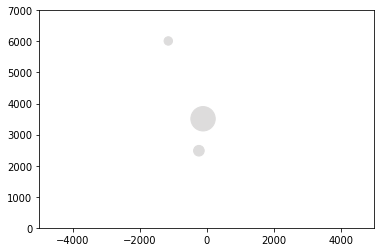

In [35]:
# detectedobjs

norm = matplotlib.colors.Normalize(vmin=-10, vmax=10, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.coolwarm)

fig, ax = plt.subplots()
scat = ax.scatter([],[],c = mapper.to_rgba([x.dopplerIdx for x in detectedobjs[0].objects]))
ax.axis([-5000,5000,0,7000])

def animate(i):
    frame = detectedobjs[i]
    scat.set_offsets([[x.x,x.y] for x in frame.objects])
    scat.set_sizes([x.peakVal for x in frame.objects ])
    scat.set_color(mapper.to_rgba([x.dopplerIdx for x in frame.objects]))
    return scat

anim = animation.FuncAnimation(fig, animate, frames=range(len(detectedobjs)))
HTML(anim.to_jshtml())
# for i in range(len(detectedobjs)):
#     ax.scatter([x.x for x in frame.objects], [x.y for x in frame.objects],c = [x.dopplerIdx for x in frame.objects], s = [x.peakVal for x in frame.objects])
#     plt.pause(0.5)
#     plt.show()


In [ ]:
rangeplot[0]

In [ ]:
fig, ax = plt.subplots()
pl, = plt.plot(range(len(rangeplot[0])),rangeplot[0])
ax.axis([0,260,0,50000])

def animate(i):
    frame = rangeplot[i]
    pl.set_data(range(len(frame)),frame)
    return scat

anim = animation.FuncAnimation(fig, animate, frames=range(len(rangeplot)))
HTML(anim.to_jshtml())